In [1]:
# Import data
from google.colab import files
files.upload()


Saving PJME_hourly.csv to PJME_hourly.csv


{'PJME_hourly.csv': b'Datetime,PJME_MW\n2002-12-31 01:00:00,26498.0\n2002-12-31 02:00:00,25147.0\n2002-12-31 03:00:00,24574.0\n2002-12-31 04:00:00,24393.0\n2002-12-31 05:00:00,24860.0\n2002-12-31 06:00:00,26222.0\n2002-12-31 07:00:00,28702.0\n2002-12-31 08:00:00,30698.0\n2002-12-31 09:00:00,31800.0\n2002-12-31 10:00:00,32359.0\n2002-12-31 11:00:00,32371.0\n2002-12-31 12:00:00,31902.0\n2002-12-31 13:00:00,31126.0\n2002-12-31 14:00:00,30368.0\n2002-12-31 15:00:00,29564.0\n2002-12-31 16:00:00,29098.0\n2002-12-31 17:00:00,30308.0\n2002-12-31 18:00:00,34017.0\n2002-12-31 19:00:00,34195.0\n2002-12-31 20:00:00,32790.0\n2002-12-31 21:00:00,31336.0\n2002-12-31 22:00:00,29887.0\n2002-12-31 23:00:00,28483.0\n2003-01-01 00:00:00,27008.0\n2002-12-30 01:00:00,27526.0\n2002-12-30 02:00:00,26600.0\n2002-12-30 03:00:00,26241.0\n2002-12-30 04:00:00,26213.0\n2002-12-30 05:00:00,26871.0\n2002-12-30 06:00:00,28679.0\n2002-12-30 07:00:00,31509.0\n2002-12-30 08:00:00,33665.0\n2002-12-30 09:00:00,34625.0\n200

In [2]:
#install keras_tuner
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 26.7 MB/s 


In [3]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras_tuner import RandomSearch
import seaborn as sns
from keras.models import Sequential
from keras.layers import  Dense,Dropout,SimpleRNN
import sklearn.preprocessing

In [4]:
#read data
df = pd.read_csv('PJME_hourly.csv')
df.head()

Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0

In [5]:
#Check for null data
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

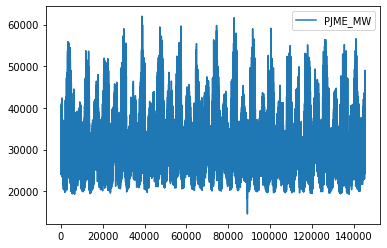

In [6]:
#Visualise data
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time(Hour)")
    plt.ylabel("Consumed energy in watt")
    plt.grid(True)

df.plot()
plt.show()

In [7]:
#Normalise data
scaler = sklearn.preprocessing.MinMaxScaler()
df_norm = scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
df_norm.shape

(145366, 1)

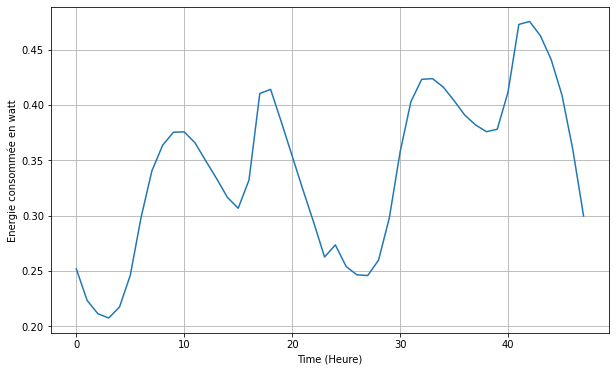

In [16]:
#Visualise normalised data
power = df_norm[0:48,:]
time = np.array(df.index[0:48])
plt.figure(figsize=(10, 6))
plot_series(time, power)

In [9]:
#Transform data to sequences 
def load_data(data, window):
    SPLIT_TIME = int(len(data) * 0.8) 
    X_data = []
    y_data = []
    for i in range(window, len(data)):
        X_data.append(data[i-window : i, 0])
        y_data.append(data[i, 0])
    
    #Divide data into test and train dataset
    X_test = X_data[SPLIT_TIME:]             
    y_test = y_data[SPLIT_TIME:]
    
    
    X_train = X_data[:SPLIT_TIME]           
    y_train = y_data[:SPLIT_TIME]
    
    #transform to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #Reshape data
    X_train = np.reshape(X_train, (SPLIT_TIME, window, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], window, 1))
    
    return [X_train, y_train, X_test, y_test]

In [10]:
window_size = 30

X_train, y_train, X_test, y_test = load_data(df_norm, window_size)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (116292, 30, 1)
y_train.shape =  (116292,)
X_test.shape =  (29044, 30, 1)
y_test.shape =  (29044,)


In [ ]:
#Model for tuning
def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(1,input_shape=(X_train.shape[1],1),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
      model.add(SimpleRNN(hp.Int('num_of_neurons1', min_value=1,max_value=16,step=1),activation="tanh",return_sequences=True))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [ ]:
#randomSearch initialization
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=12,
        executions_per_trial=2
        )

In [ ]:
#Tuner parameters
tuner.search_space_summary()

Search space summary
Default search space size: 3
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
num_of_neurons1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 16, 'step': 1, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [ ]:
#Start Tuning
tuner.search( x=X_train,y=y_train, epochs=1,validation_data=(X_test,y_test))

Trial 12 Complete [00h 02m 49s]
mse: 0.021066422574222088

Best mse So Far: 0.019881628453731537
Total elapsed time: 00h 31m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#Tuning results
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
n_layers: 2
num_of_neurons1: 13
Dropout_rate: 0.1
Score: 0.019881628453731537
Trial summary
Hyperparameters:
n_layers: 2
num_of_neurons1: 7
Dropout_rate: 0.0
Score: 0.020090115256607533
Trial summary
Hyperparameters:
n_layers: 1
num_of_neurons1: 9
Dropout_rate: 0.1
Score: 0.020161896012723446
Trial summary
Hyperparameters:
n_layers: 3
num_of_neurons1: 7
Dropout_rate: 0.0
Score: 0.021066422574222088
Trial summary
Hyperparameters:
n_layers: 3
num_of_neurons1: 15
Dropout_rate: 0.4
Score: 0.021555188111960888
Trial summary
Hyperparameters:
n_layers: 2
num_of_neurons1: 6
Dropout_rate: 0.5
Score: 0.02249255497008562
Trial summary
Hyperparameters:
n_layers: 3
num_of_neurons1: 8
Dropout_rate: 0.2
Score: 0.02263925690203905
Trial summary
Hyperparameters:
n_layers: 2
num_of_neurons1: 15
Dropout_rate: 0.4
Score: 0.0233382573351264
Trial summary
Hyperparameters:
n_layers: 2
num_of_neurons1: 6
Dropou

In [11]:
#New model with optimized parameters
model = Sequential()
model.add(SimpleRNN(1,input_shape=(X_train.shape[1],1),return_sequences=True))
model.add(SimpleRNN(13,activation="tanh",return_sequences=True))
model.add(SimpleRNN(13,activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(1))

In [12]:
#Compilation et execution
model.compile(optimizer="adam",loss="MSE")
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
3635/3635 [==============================] - 264s 69ms/step - loss: 0.0034
Epoch 2/10
3635/3635 [==============================] - 235s 65ms/step - loss: 0.0011
Epoch 3/10
3635/3635 [==============================] - 236s 65ms/step - loss: 7.2245e-04
Epoch 4/10
3635/3635 [==============================] - 242s 67ms/step - loss: 5.7670e-04
Epoch 5/10
3635/3635 [==============================] - 238s 66ms/step - loss: 5.2129e-04
Epoch 6/10
3635/3635 [==============================] - 237s 65ms/step - loss: 4.9115e-04
Epoch 7/10
3635/3635 [==============================] - 236s 65ms/step - loss: 4.6918e-04
Epoch 8/10
3635/3635 [==============================] - 235s 65ms/step - loss: 4.5383e-04
Epoch 9/10
3635/3635 [==============================] - 236s 65ms/step - loss: 4.5456e-04
Epoch 10/10
3635/3635 [==============================] - 233s 64ms/step - loss: 4.4683e-04


In [13]:
#Score
from sklearn.metrics import r2_score
predictions = model.predict(X_test)

score = r2_score(y_test, predictions)
print("R^2 Score du model RNN = ",score)

R^2 Score du model RNN =  0.9796844697969351


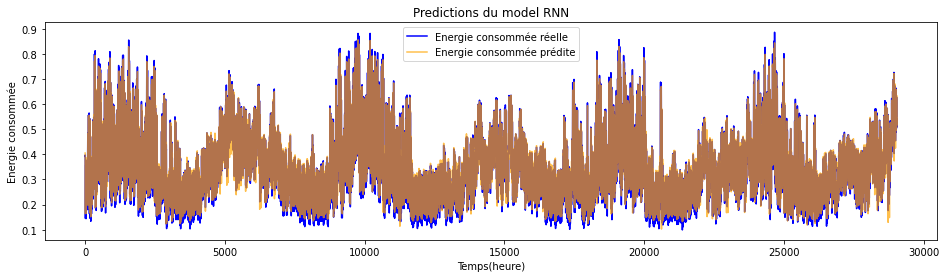

In [15]:
#Real and predicted values comparaison
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Real consumed energy')
    plt.plot(predicted, alpha=0.7, color='orange',label='predicted consumed energy')
    plt.title(title)
    plt.xlabel('Time(hour)')
    plt.ylabel('Consumed energy')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, predictions, "RNN model predictions")